# Imports

In [1]:
import os
import pandas as pd


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score, log_loss,confusion_matrix,roc_curve


In [3]:
X_train,X_test,X_val,y_train,y_test,y_val = pd.read_csv('datasets/X_train.csv'),pd.read_csv('datasets/X_test.csv' ),pd.read_csv('datasets/X_val.csv' ),pd.read_csv('datasets/y_train.csv'),pd.read_csv('datasets/y_test.csv'),pd.read_csv('datasets/y_val.csv')
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score, log_loss

# Logistic Regression

## Model Training

In [6]:
%pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.3 MB/s eta 0:00:00


In [7]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

y_train = np.ravel(y_train)

def objective(trial):
    # Define hyperparameters to be optimized
    r = trial.suggest_float('l1_ratio', 0, 1, log=False)
    c = trial.suggest_float('C', 1e-10, 1000, log=True)

    # Create logistic regression model with specified hyperparameters
    model = LogisticRegression(penalty='elasticnet',solver='saga', l1_ratio=r, C=c)

    # Evaluate model using cross-validation
    cv_score = cross_val_score(model, X_train, y_train, cv=5,scoring = "neg_log_loss")

    # Return negative mean accuracy as Optuna aims to minimize the objective
    return -cv_score.mean()

# Create Optuna study
study = optuna.create_study(direction='minimize')

# Optimize hyperparameters
study.optimize(objective, n_trials=100)

# Get best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train logistic regression classifier with best hyperparameters
best_model = LogisticRegression(**best_params, solver='saga', random_state=42)
best_model.fit(X_train, y_train)

[I 2024-05-07 14:40:20,263] A new study created in memory with name: no-name-c90f7e47-a19d-4925-b390-abb87d6ad4d6
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-05-07 14:40:58,282] Trial 0 finished with value: 0.44400240880228276 and parameters: {'l1_ratio': 0.9124054312919395, 'C': 1.046290167209632}. Best is trial 0 with value: 0.44400240880228276.
[I 2024-05-07 14:40:59,758] Trial 1 finished with value: 0.6931404266494209 and parameters: {'l1_ratio': 0.531832531902274, 'C': 4.2215012814058674e-05}. Best is

Best hyperparameters: {'l1_ratio': 0.8431633134631452, 'C': 0.6440911836134244}


LogisticRegression(C=0.6440911836134244, l1_ratio=0.8431633134631452,
                   random_state=42, solver='saga')

## Model Testing

### Classification report

In [8]:
# Evaluate on test set and Make clasification Report
y_pred = best_model.predict(X_test)
class_rep = classification_report(y_test, y_pred,digits=4)
print(class_rep)

              precision    recall  f1-score   support

          No     0.7814    0.7959    0.7886      4782
         Yes     0.7920    0.7773    0.7846      4782

    accuracy                         0.7866      9564
   macro avg     0.7867    0.7866    0.7866      9564
weighted avg     0.7867    0.7866    0.7866      9564



### ROC curve and Confusion Matrix

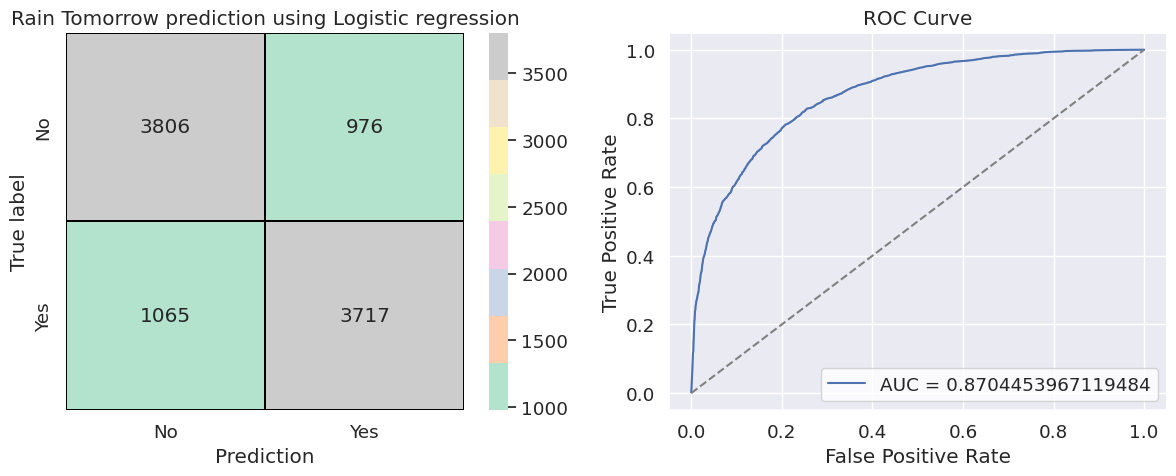

In [12]:
mapping = {'Yes':1,'No':0}
y_test_map = y_test.copy()
y_test_map["RainTomorrow"] = y_test_map["RainTomorrow"].map(mapping)


# Plot confusion matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Pastel2',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'],
            linecolor='black',linewidths=1.3)
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('Rain Tomorrow prediction using Logistic regression')

# Plot ROC curve
plt.subplot(1, 2, 2)
mapping = {'Yes': 1, 'No': 0}
y_test_map = y_test.copy()
y_test_map["RainTomorrow"] = y_test_map["RainTomorrow"].map(mapping)

y_probs = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test_map, y_probs)
fpr, tpr, _ = roc_curve(y_test_map, y_probs)

sns.set_style('whitegrid')
sns.lineplot(x=fpr, y=tpr, label=f'AUC = {auc_score}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Coeficient Plot

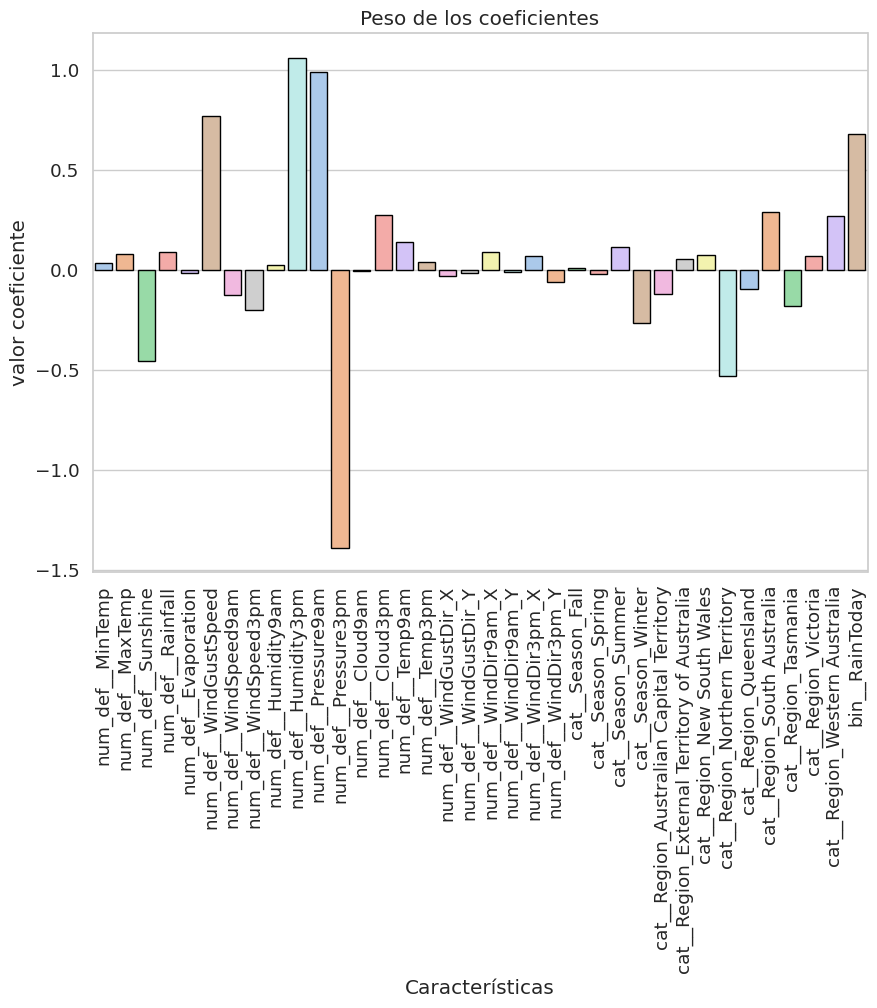

In [11]:
# Coeficients importance Plot

coeficientes = best_model.coef_
nombres_caracteristicas = X_train.columns

df_coef = pd.DataFrame({'Index': nombres_caracteristicas,'coeficientes': coeficientes[0]})

plt.figure(figsize=(10,7))
sns.barplot(x='Index', y='coeficientes', data=df_coef,palette='pastel',edgecolor='black',hue='Index',legend=False)
plt.xlabel('Características')
plt.ylabel('valor coeficiente')
plt.tick_params(axis='x',rotation = 90)
plt.title('Peso de los coeficientes')
plt.show()
